<a href="https://colab.research.google.com/github/abtheo/BrainReadWrite/blob/master/Neural_Decoding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Brain Reading & Writing: Neural Decoding


---


In this notebook, will implement a neural decoder for reconstructing perceived stimuli from brain responses. We will be using the dataset that was previously used in a number of papers. You can refer them for more details on the dataset and/or the method.

The dataset contains fMRI data acquired from the early visual cortex of one subject as the subject was presented with 100 grayscale images of handwritten sixes and nines (50 sixes and 50 nines). The fMRI data has been realigned and slice time corrected. Furthermore, stimulus specific response amplitudes have been estimated with a general linear model.

Let's first familiarize ourselves with the dataset. It contains a number of variables:

* **X** -> This is a 100 x 784 matrix. The ith row contains the pixel values of the stimulus that was presented in the ith trial of the experiment. Note that the stimuli are 28 pixel x 28 pixel images, which were reshaped to 1 x 784 vectors.

* **Y** -> This is a 100 x 3092 matrix. The ith row contains the voxel values of the responses that were measured in the ith trial of the experiment.

* **X_prior** -> This is a 2000 x 784 matrix. Each row contains the pixel values of a different stimulus, which was not used in the experiment. Note that the stimuli are 28 pixel x 28 pixel images, which were reshaped to 1 x 784 vectors.

Note: In the remainder of this document, we will use **x** for referring to a 784 x 1 stimulus vector and **y** for referring to a 3092 x 1 response vector.


# 1. Data Visualization

* Load the dataset.

* Visualize some of the stimuli.

* Normalize X and Y to have zero mean and unit variance

* Split X and Y in two parts called X_training and X_test, and Y_training and Y_test. The training set contains 80 stimulus-response pairs (40 pairs for sixes and 40 pairs for nines). The test set contains 20 stimulus-response pairs (10 pairs for sixes and 10 pairs for nines).

In [3]:
###Dependencies
from scipy.io import loadmat
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np

import keras
from keras.layers import *
from keras.models import Model
from keras.callbacks import *

In [4]:
"""Setting Root Directory:
Change root_dir to your relative path to the tutorial folder."""
!git clone "https://github.com/abtheo/BrainReadWrite/" ./temp    # clone github repository to temp folder
!mkdir /content/data
!mv ./temp/data/* /content/data      # move all files/folders in temp folder to folder defined in project path
!rm -rf ./temp                      # remove all the files/folders in temp folder

root_dir = "/content/data/"

#Load data
data = loadmat('/content/data/69dataset2.mat')

Cloning into './temp'...
remote: Enumerating objects: 21, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 21 (delta 3), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (21/21), done.


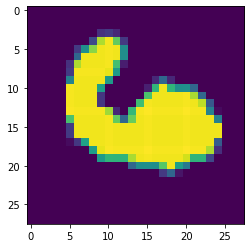

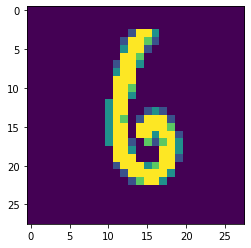

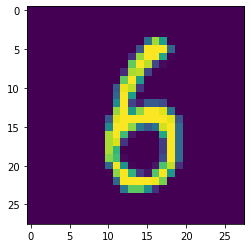

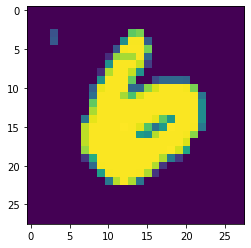

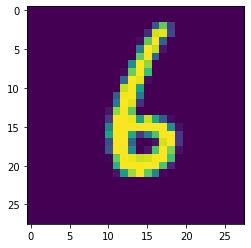

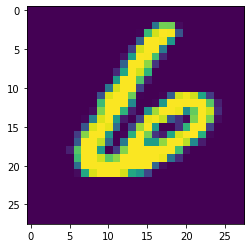

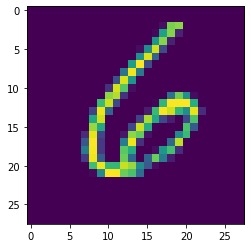

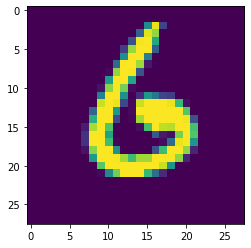

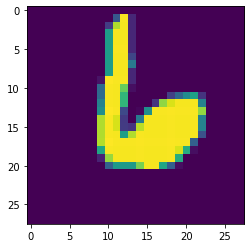

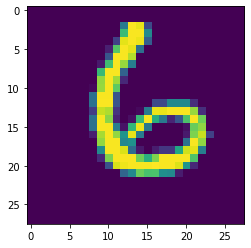

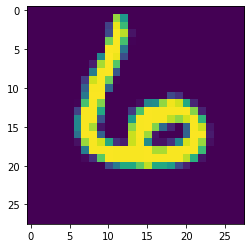

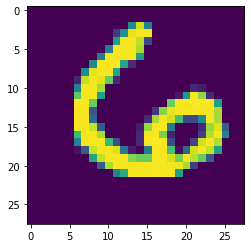

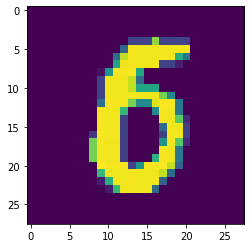

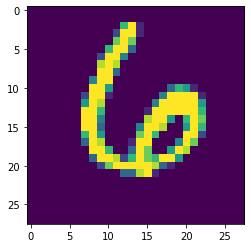

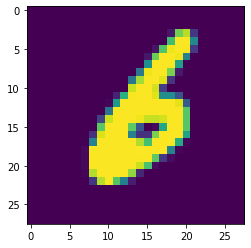

In [ ]:
#Visualise some examples
for i in range(15):
    item = data["X"][i]
    item = item.reshape(28, 28)
    plt.imshow(item.T)
    plt.show()

In [ ]:
X = data["X"]
Y = data["Y"]

#Normalisation -
#StandardScaler class subtracts the mean and divides by the standard deviation,
#and saves these coefficients to enable later inverse transformation.
x_scaler= StandardScaler(with_mean=True, with_std=True)
y_scaler= StandardScaler(with_mean=True, with_std=True)

X_norm = x_scaler.fit_transform(X)
Y_norm = y_scaler.fit_transform(Y)

X_norm = np.nan_to_num(X_norm)
Y_norm = np.nan_to_num(Y_norm)

In [ ]:
#Train - test split
X_training = X_norm[:80]
X_testing = X_norm[80:]

Y_training = Y_norm[:80]
Y_testing = Y_norm[80:]

print(X_training.shape, X_testing.shape, Y_training.shape, Y_testing.shape)

(80, 784) (20, 784) (80, 3092) (20, 3092)


#2. Neural Reconstruction

Our goal is to solve the problem of reconstructing **x** from **y**. One possible approach to solve this problem is to use a *discriminative* model. Discriminative models predict **x** as a function of **y**. That is:

**x** = f(**y**)

We will assume that f is a linear function. That is:

**x** = **B'** **y**

f can be seen as a very simple linear neural network comprising one layer of weights (i.e., **B**). We can estimate **B** in close form with ridge regression. That is:

**B** = inv(**Y**\_training' **Y**\_training + lambda **I**) **Y**\_training' **X**\_training

where lambda is the regularization coefficient, **I** is the *q* x *q* identity matrix, and *q* is the number of voxels. Note that we can safely ignore the intercept since we normalized our data to have zero mean and unit variance.



* Estimate **B** on the training set. Note: Normally, you should use cross validation to estimate lambda. For simplicity, we assume that lambda = 10 ^ -6.

* Reconstruct **x** from **y** in the test set.

* Visualize the reconstructions.

In [ ]:
lam = 1e-6 
#Find B
inverse = np.dot(Y_training.T, Y_training) + np.dot(lam, np.identity(3092))
thing = np.linalg.solve(inverse, Y_training.T)

B = np.dot(thing, X_training)

In [ ]:
#Estimate X from Y * B'
X_est = []
for i in range(20):
    x = np.dot(B.T, Y_testing[i])
    X_est.append(x)

X_est = np.array(X_est)
X_est = x_scaler.inverse_transform(X_est)
print(X_est.shape)

(20, 784)


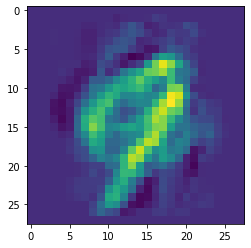

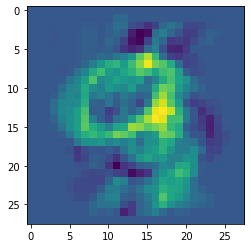

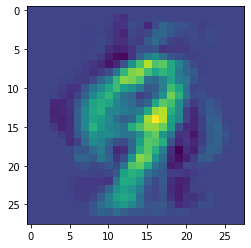

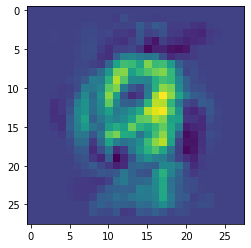

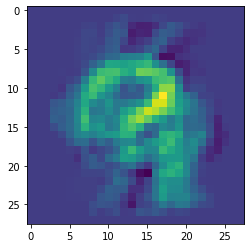

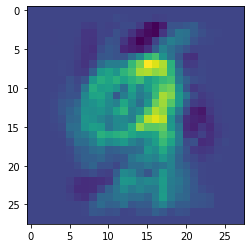

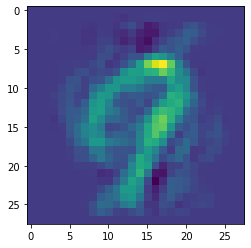

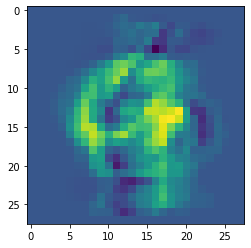

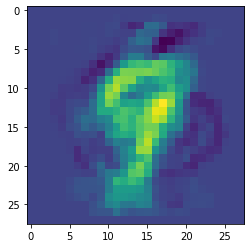

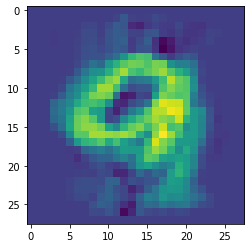

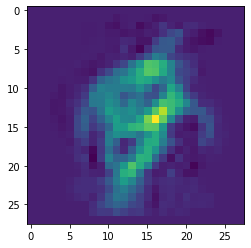

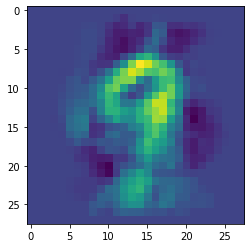

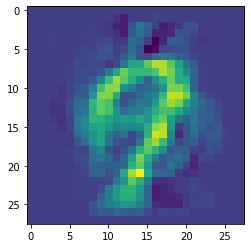

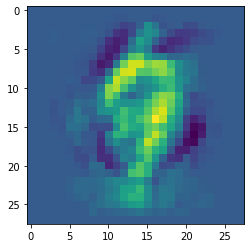

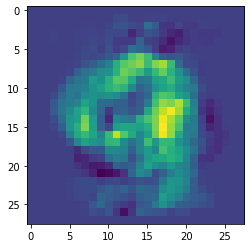

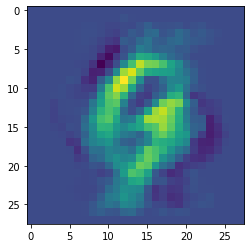

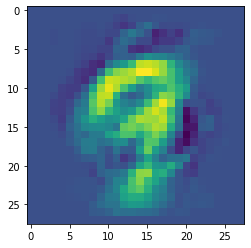

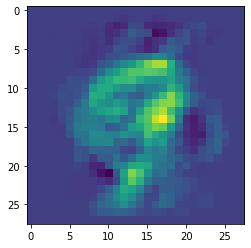

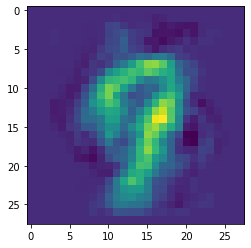

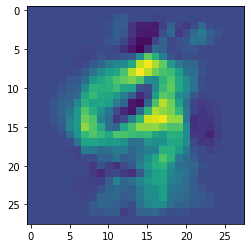

In [ ]:
#Visualise some examples
for i in range(20):
    item = X_est[i]
    item = item.reshape(28, 28)
    plt.imshow(item.T)
    plt.show()

Another possible approach to solve the problem of reconstructing **x** from **y** is to use a *generative* model and invert it with Bayes' rule. We reformulate the problem as finding the most probable **x** that could have caused **y**. That is:

argmax_**x** P(**x** | **y**)

where P(**x** | **y**) is called the posterior (probability of the stimulus being **x** if the observation is **y**). In other words, we have to define the posterior, estimate its parameters and find the argument that maximizes it, which will be the reconstruction of **x** from **y**. While, this may seem daunting, it actually has a simple solution. The posterior assigns a probability to an event by combining our observations and beliefs about it, and can be decomposed with Bayes' rule as the product of how likely our observations are given the event (probability of observing **y** if the stimulus is **x**) and how likely the event is independent of our observations (probability of the stimulus being **x**). That is:

P(**x** | **y**) ~ P(**y** | **x**) * P(**x**)

where P(**y** | **x**) is called the likelihood and P(x) is called the prior.

We will assume that the likelihood and the prior are multivariate Gaussian distributions. A Gaussian is characterized by two parameters: a mean vector and a covariance matrix. In the case of the likelihood, the mean of the Gaussian is given by:

**mu**\_likelihood = **B'** **x**

As before, we can estimate **B** in close form with ridge regression:

**B** = inv(**X**\_training' **X**\_training + lambda **I**) **X**\_training' **Y**\_training

where lambda is the regularization coefficient, I is the *p* x *p* identity matrix, and *p* is the number of pixels. The covariance matrix of the likelihood is given by:

**Sigma**_likelihood = diag(E[||**y** - **B'** **x**|| ^ 2]). 

In the case of the prior, the mean of the Gaussian is given by:

**mu**\_prior = **0** (which is a vector of zeros)

The covariance matrix of the prior is given by:

**Sigma**\_prior = **X**\_prior' * **X**\_prior / (n - 1)

where n is the length of **X**\_prior.

#3.  Solving Bayes' Rule 

---



* Estimate **B** on the training set. Note: Normally, you should use cross-validation to estimate lambda and Sigma_likelihood. For simplicity, we  assume that lambda = 10 ^ -6 and Sigma_likelihood = 10 ^ -3 **I**.

* Estimate **Sigma**\_prior. 

* Visualize **Sigma**\_prior.

In [ ]:
X_prior = data["X_prior"]
x_p_scaler = StandardScaler(with_mean=True, with_std=True)
X_p_norm = x_p_scaler.fit_transform(X_prior)
X_p_norm = np.nan_to_num(X_p_norm)

In [ ]:
#Find covariance matrix
sigma_prior = np.dot(X_p_norm.T, X_p_norm) / (len(X_prior) - 1)

#Regularize
sigma_prior = (np.diagonal(sigma_prior) * 1e-6) + sigma_prior
print(sigma_prior.shape)

(784, 784)


##Visualising Sigma Prior
This plot shows the correlation between pixels of images from X_prior. Each row and column represent a single image. Each pixel in the plot tells how much it is on average correlated to its neighboring pixels. 

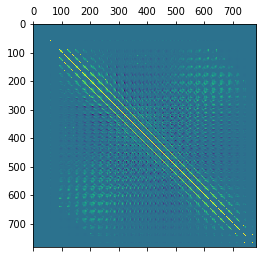

In [ ]:
#Plot heatmat of correlations
plt.matshow(sigma_prior)

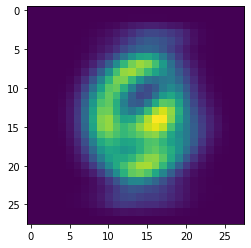

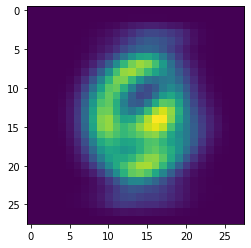

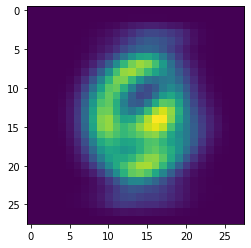

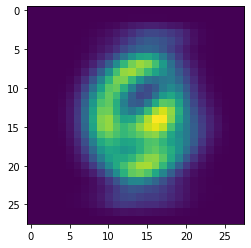

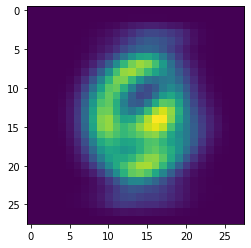

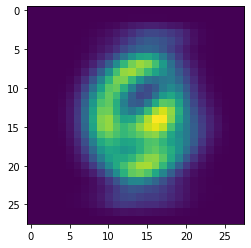

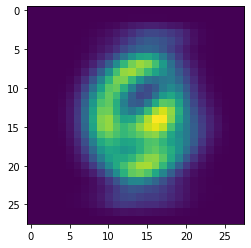

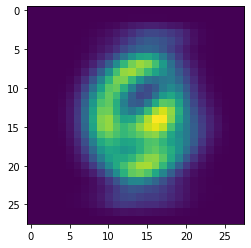

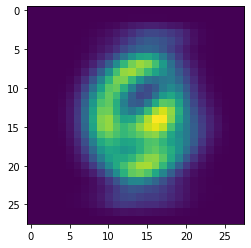

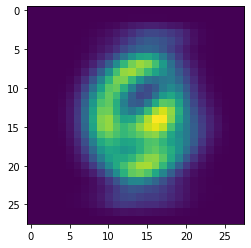

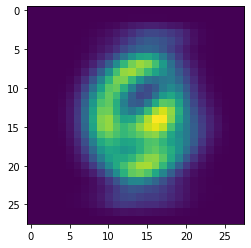

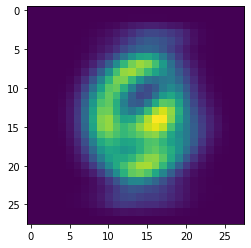

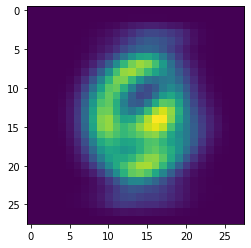

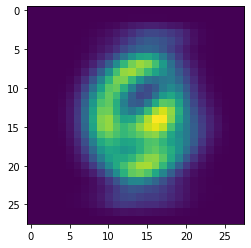

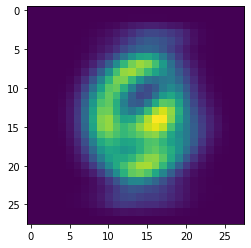

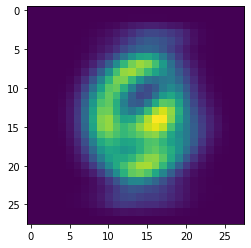

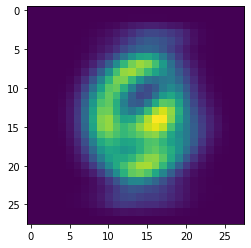

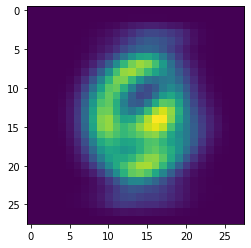

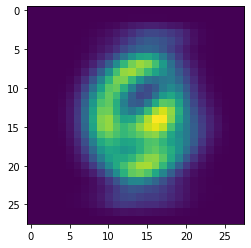

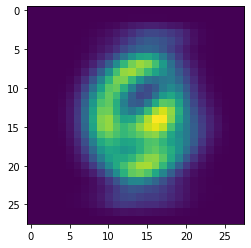

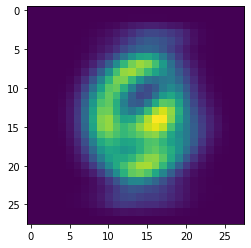

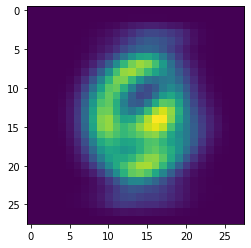

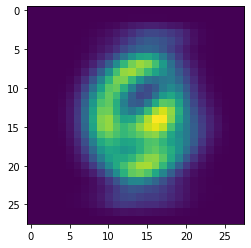

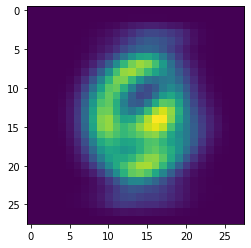

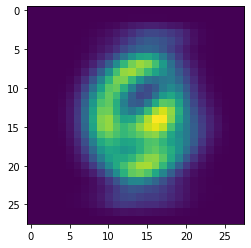

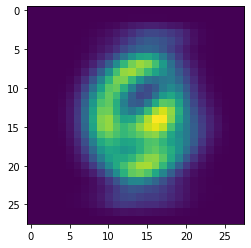

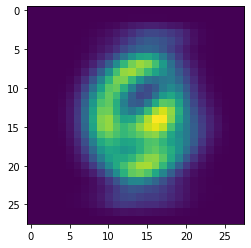

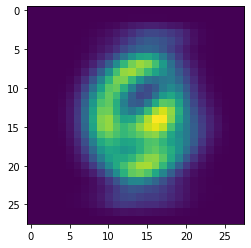

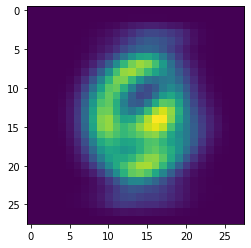

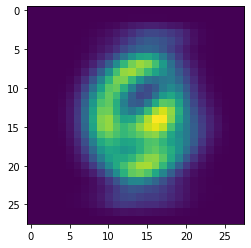

In [ ]:
#Plot some row examples
for i in range(5, 35):
    pixel = x_p_scaler.inverse_transform(sigma_prior)[i].reshape((28, 28))
    plt.imshow(pixel.T)
    plt.show()

Having defined the likelihood and the prior as Gaussians, we can derive the posterior by multiplying them. It turns out that the product of two Gaussians is another Gaussian, whose mean vector is given by:

**mu**\_posterior = inv(inv(**Sigma**\_prior) + **B** inv(**Sigma**\_likelihood) **B**') **B** * inv(**Sigma**\_likelihood) **y**

We are almost done. Recall that the reconstruction of **x** from **y** is the argument that maximizes the posterior, which we derived to be a Gaussian. We will be completely done once we answer the following question: What is the argument that maximizes a Gaussian?


The answer is its mean vector, which is the solution of our initial problem. That is:

argmax_**x** P(**x** | **y**) =  
**mu**\_posterior =  
inv(inv(**Sigma**\_prior) + **B** inv(**Sigma**\_likelihood) **B**') **B** * inv(**Sigma**\_likelihood) **y**

Now, we can plug any **y** in the above equation and reconstruct the most probable **x** that could have caused it.


#4.  Visualizing Reconstructions

The first results are better because they are reconstructed directly from stimulus images. The second set is reconstructed from the X_prior distribution, which were not used in the experimental trials.

In [ ]:
lam = 1e-6 
sigma_likelihood = 1e-3 * np.eye(3092)
inv_sigma_likelihood = 1e3 * np.eye(3092)

inverse = np.dot(X_training.T, X_training) + np.dot(lam, np.identity(784))
thing = np.linalg.solve(inverse, X_training.T)

B = np.dot(thing, Y_training)

In [ ]:
def inv(m):
    a, b = m.shape
    if a != b:
        raise Exception("Not same shape")
        
    i = np.eye(a, a)
    return np.linalg.lstsq(m, i)[0]

inv_sigma_prior = inv(sigma_prior)

inverse_brackets = inv(inv_sigma_prior + B@inv_sigma_likelihood@B.T)
formula = inverse_brackets@B@inv_sigma_likelihood
formula.shape


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  import sys


(784, 3092)

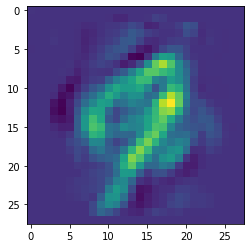

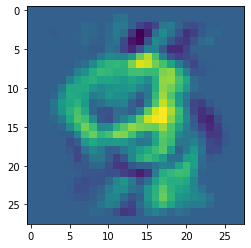

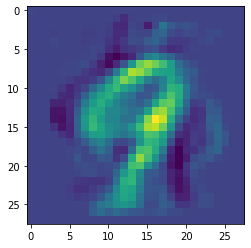

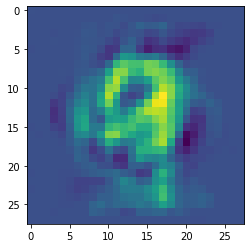

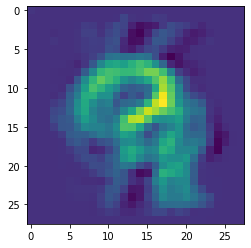

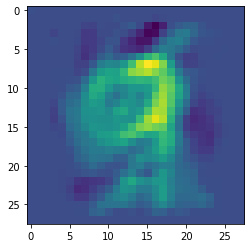

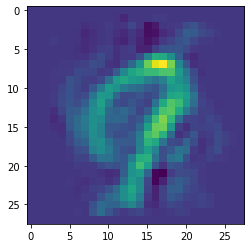

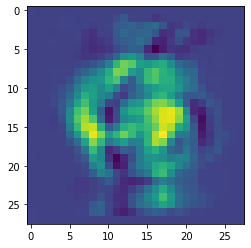

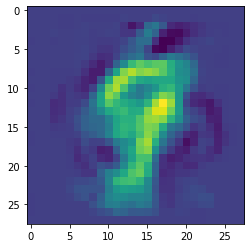

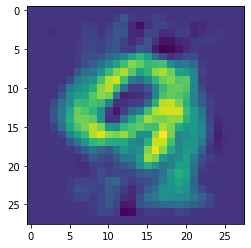

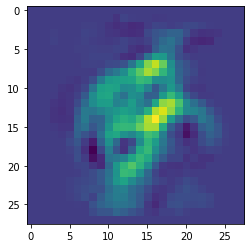

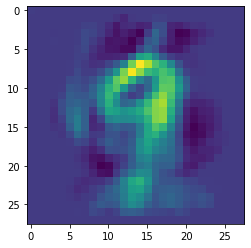

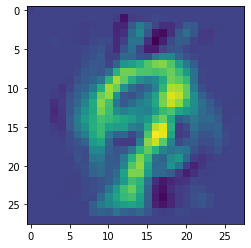

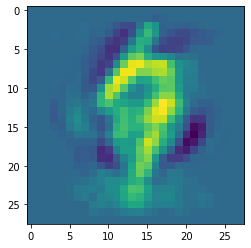

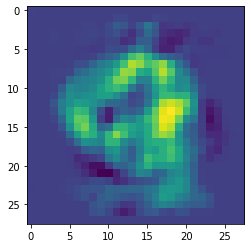

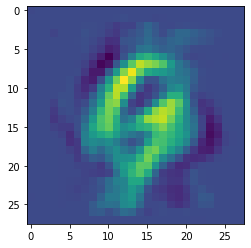

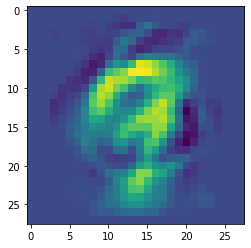

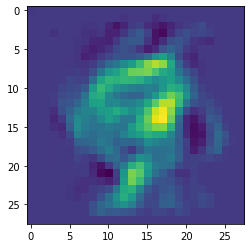

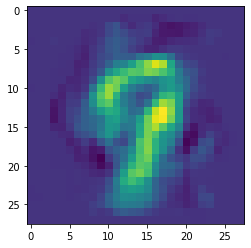

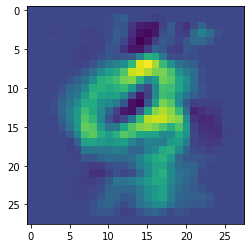

In [ ]:
#Reconstruct using formula, then un-normalise
X_recons = x_scaler.inverse_transform(np.array([formula@y for y in Y_testing]))
for i in range(len(X_recons)):
    plt.imshow(X_recons[i].reshape((28,28)).T)
    plt.show()

Now the real fight begins! You might have already realized that the second approach is very similar to the one in the face reconstruction paper that we have discussed in the last lecture. The main difference is how the stimuli are encoded. So far, we have been encoding the stimuli with an identity transformation:

**mu**\_likelihood = **B'** g(**x**)

where g(**x**) = **x**

In the paper, they are encoded as the features extracted from a DNN:

**mu**\_likelihood = **B'** DNN(**x**)

Similarly, we have been decoding the responses with MAP estimation of the stimuli:

g ^ -1(argmax_g(**x**) P(g(**x**) | **y**))

where g ^ -1(**y**) = **y**

In the paper, they are decoded with MAP estimation of the features followed by an inverse DNN:

DNN ^ -1(argmax_DNN(**x**) P(DNN(**x**) | **y**))

# Neural Network Classifiers

---



- Train a simple DNN for digit classification on the MNIST dataset.
- Select an indermediate layer of the DNN as your feature extractor.
- Train another simple DNN to invert the first DNN. That is, it should transform features extracted by the selected layer of the first DNN to stimuli.
- Repeat Steps 3 and 4 but use the trained DNNs instead of identity transformation.

In [ ]:
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32')/255.
x_test = x_test.astype('float32')/255.

x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

print(x_train.shape, y_train.shape)


11493376/11490434 [==============================] - 0s 0us/step
(60000, 28, 28, 1) (60000, 10)


In [ ]:
############
# Encoding #
############

"""
Alright, I definitely should have done this in PyTorch rather than Keras.
The idea is to train a classifier on MNIST,
then use a hidden latent layer to encode our X data.

Our implementation is suuuuper hacky;
The encoder model has two output layers -
One for classification,
One to expose the latent layer.

Tensors flow through the latent layer to the classification output layer,
in an attempt to force the layer to learn feature representations of digits.
"""

#Latent layer does not need to learn! (Hack)
def fake_loss(y_true, y_pred):
    return 0 * keras.losses.binary_crossentropy(y_true,y_pred)

input_img = Input(shape=(28, 28, 1)) 
# Conv1 #
x = Conv2D(16, kernel_size = (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D(pool_size = (2, 2), padding='same')(x)
x = Dropout(0.2)(x)
# Conv2 #
x = Conv2D(8, kernel_size = (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size = (2, 2), padding='same')(x) 
x = Dropout(0.2)(x)

# Conv 3 #
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
z = MaxPooling2D(pool_size = (2, 2), padding='same')(x)
x = Dropout(0.2)(x)

"""Here, we branch the model into two output directions:
Z: Exposing the latent layer itself
class_out: A classifier for MNIST, forcing the latent layer to learn useful features
"""
z = Flatten()(z)
z = Dense(128, name='z')(z)

#Flows from Z, forcing the Z layer to learn a representation for classification
class_out = Dense(10, activation='softmax', name='class_out')(z)

classifier_encoder = Model(input_img, [class_out,z])
classifier_encoder.compile(optimizer='adam', 
                          loss={'class_out': 'categorical_crossentropy','z': fake_loss})
classifier_encoder.summary()






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________

In [ ]:
"""Train classifier / encoder model"""

#Callbacks:
#Reduce LR on plataeu to smooth learning gradient
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.5,
                            patience=4, min_lr=1e-5)
#Save best model from training
checkpoint_callback = ModelCheckpoint("encoder.h5", monitor='val_loss', verbose=1, save_best_only=True, mode='min')
#Only stop training once the model has completely converged
early_stopping = EarlyStopping(monitor='val_loss', patience=10, min_delta=1e-4)

callbacks = [reduce_lr, checkpoint_callback, early_stopping]
#Sorry for the hacky double output!
classifier_encoder.fit(x=x_train, 
                       y={"class_out": y_train, "z": np.zeros(shape=(y_train.shape[0],1))}, 
                       callbacks=callbacks,
                       epochs=50, 
                       validation_data=(x_test,{"class_out" : y_test, "z" : np.zeros(shape=(y_test.shape[0],1))}))
#Load best model
classifier_encoder.load_weights("encoder.h5")




Train on 60000 samples, validate on 10000 samples
Epoch 1/50





60000/60000 [==============================] - 35s 577us/step - loss: 0.3290 - class_out_loss: 0.3290 - z_loss: 0.0000e+00 - val_loss: 0.0965 - val_class_out_loss: 0.0965 - val_z_loss: 0.0000e+00

Epoch 00001: val_loss improved from inf to 0.09645, saving model to encoder.h5
Epoch 2/50
60000/60000 [==============================] - 21s 357us/step - loss: 0.1359 - class_out_loss: 0.1359 - z_loss: 0.0000e+00 - val_loss: 0.0680 - val_class_out_loss: 0.0680 - val_z_loss: 0.0000e+00

Epoch 00002: val_loss improved from 0.09645 to 0.06801, saving model to encoder.h5
Epoch 3/50
60000/60000 [==============================] - 21s 355us/step - loss: 0.1137 - class_out_loss: 0.1137 - z_loss: 0.0000e+00 - val_loss: 0.0569 - val_class_out_loss: 0.0569 - val_z_loss: 0.0000e+00

Epoch 00003: val_loss improved from 0.06801 to 0.05694, saving model to encoder.h5
Epoch 4/50
60000/60000 [==============================] - 22s 359us/step 

In [ ]:
############
# Decoding #
############

"""
As we flattened our convolutional filters in order to produce a flat latent Z
we must undo this operation for the decoder network.

Encoder:
(MaxPooling) (None, 4, 4, 8) -> (Flatten) (128)
Decoder:
(Flatten) (128) -> (Reshape) (4, 4, 8)
"""
decoder_in = Input(shape=(128,))
x = Reshape((4, 4, 8))(decoder_in)
# DeConv1
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Dropout(0.2)(x)
# DeConv2
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Dropout(0.2)(x)

# Deconv3
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
x = Dropout(0.2)(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

decoder = Model(decoder_in, decoded)
decoder.compile(optimizer='adam', loss='binary_crossentropy')
decoder.summary()



Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 128)               0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 4, 4, 8)           0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 4, 4, 8)           584       
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 8, 8, 8)           0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 8, 8, 8)           0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 8, 8, 8)           584       
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 16, 16, 8)         0  

In [ ]:
#Use trained classifier/encoder to generate latent vectors from Xs
Z_train = classifier_encoder.predict(x_train)[1]

#Callbacks:
#Reduce LR on plataeu to smooth learning gradient
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.5,
                            patience=4, min_lr=1e-5)
#Save best model from training
checkpoint_callback = ModelCheckpoint("decoder.h5", monitor='val_loss', verbose=1, save_best_only=True, mode='min')
#Only stop training once the model has completely converged
early_stopping = EarlyStopping(monitor='val_loss', patience=10, min_delta=1e-4)

callbacks = [reduce_lr, checkpoint_callback, early_stopping]

#Fit model to map from latent back to images
decoder.fit(Z_train, 
            x_train, 
            epochs = 50,
            callbacks=callbacks,
            batch_size = 32, 
            validation_split=0.2)
#Load best model
decoder.load_weights("decoder.h5")

Train on 48000 samples, validate on 12000 samples
Epoch 1/50
48000/48000 [==============================] - 14s 292us/step - loss: 0.2586 - val_loss: 0.2165

Epoch 00001: val_loss improved from inf to 0.21653, saving model to decoder.h5
Epoch 2/50
48000/48000 [==============================] - 13s 278us/step - loss: 0.2245 - val_loss: 0.2067

Epoch 00002: val_loss improved from 0.21653 to 0.20674, saving model to decoder.h5
Epoch 3/50
48000/48000 [==============================] - 13s 278us/step - loss: 0.2194 - val_loss: 0.2036

Epoch 00003: val_loss improved from 0.20674 to 0.20364, saving model to decoder.h5
Epoch 4/50
48000/48000 [==============================] - 13s 271us/step - loss: 0.2172 - val_loss: 0.2017

Epoch 00004: val_loss improved from 0.20364 to 0.20175, saving model to decoder.h5
Epoch 5/50
48000/48000 [==============================] - 13s 272us/step - loss: 0.2157 - val_loss: 0.2008

Epoch 00005: val_loss improved from 0.20175 to 0.20079, saving model to decoder.h5

Example Z-vector:
[-1.2128648   1.9531142   0.56698334 -0.18517938 -0.9932102  -0.5769521
  2.034906   -0.4373963  -1.8547826   0.6760388  -0.82971656  0.19357386
 -0.94301915 -2.5114806  -0.19042638 -0.88983256 -0.29691646  0.771271
 -1.3054831  -0.52020746  0.0191184  -1.3788337  -0.03879342  2.0473263
  0.87316996  0.91369617  0.01832938 -0.1376684   0.22466466 -0.35524982
 -0.45628753  0.2743409   0.58263826 -0.03116002 -1.0970061  -0.40607408
 -0.5110997   0.04650801 -0.2162134   1.2933252   1.8098778  -0.02590972
 -0.6191393  -0.72956157  0.31140822  1.1256343   0.9192324  -0.57055074
 -1.9632415  -1.5730481  -0.03844482  1.0795285  -0.60443497 -1.2251091
 -1.0886701  -1.8053073  -0.18969171  0.47930568 -0.61156607  0.79333854
  0.26400632 -0.63002217  0.61150414  0.28033707  0.8005959  -0.42470795
 -1.4780344   0.36086205 -0.28334892  0.34467143 -0.4312017   1.484664
 -0.14534667 -0.05553595  0.29996085  0.10399915  0.9496803  -0.38815385
  1.0179155   0.36775455  0.95836854 -2.

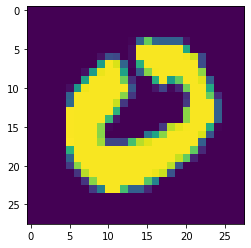

Reconstructed MNIST:  0


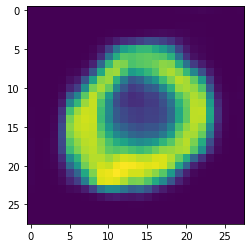

Original MNIST:  7


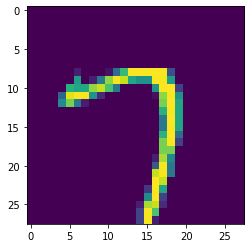

Reconstructed MNIST:  7


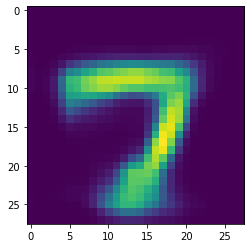

Original MNIST:  4


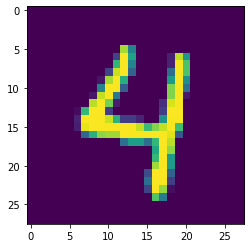

Reconstructed MNIST:  4


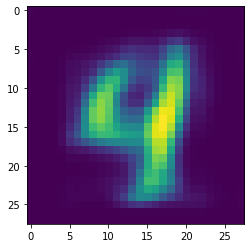

Original MNIST:  0


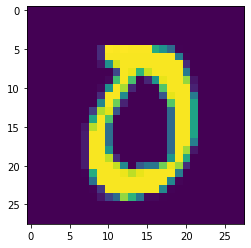

Reconstructed MNIST:  0


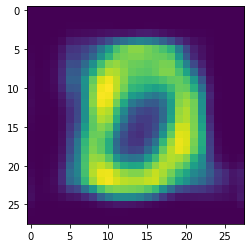

Original MNIST:  1


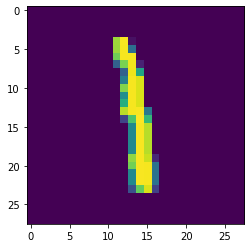

Reconstructed MNIST:  1


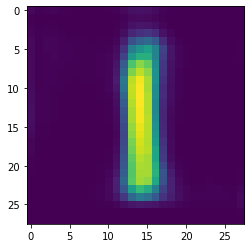

Original MNIST:  3


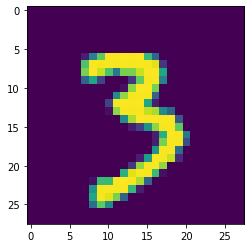

Reconstructed MNIST:  3


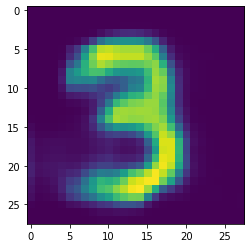

Original MNIST:  1


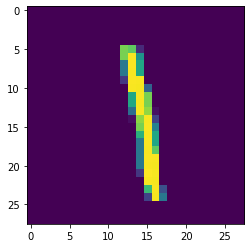

Reconstructed MNIST:  1


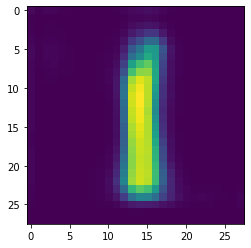

Original MNIST:  3


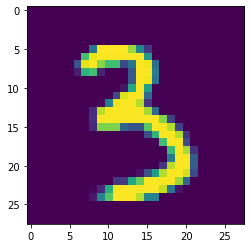

Reconstructed MNIST:  3


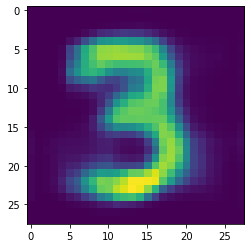

Original MNIST:  4


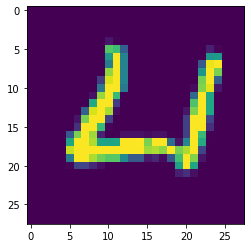

Reconstructed MNIST:  4


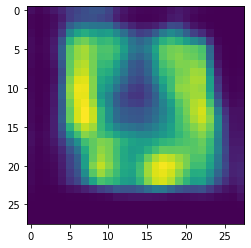

Original MNIST:  7


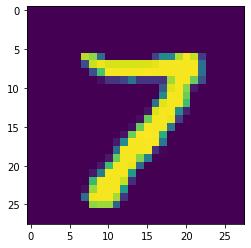

Reconstructed MNIST:  7


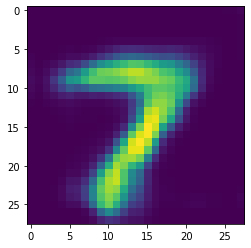

In [ ]:
#Visualise some MNIST reconstructions!
classes, Z_vectors = classifier_encoder.predict(x_test)
reconstructed = decoder.predict(Z_vectors)
print("Example Z-vector:")
print(Z_vectors[0])
for i in range(25,35):
  print("Original MNIST: ", np.argmax(y_test[i]))
  plt.imshow(x_test[i].reshape(28,28))
  plt.show()
  print("Reconstructed MNIST: ", np.argmax(classes[i]))
  plt.imshow(reconstructed[i].reshape(28,28))
  plt.show()
  
  print("============")
  

In [ ]:
lam = 1e-6 
sigma_likelihood = 1e-3 * np.eye(3092)
inv_sigma_likelihood = 1e3 * np.eye(3092)

X_train_imshape = X_training.reshape((X_training.shape[0], 28, 28, 1))

_, Z = classifier_encoder.predict(X_train_imshape)
#Find B
inverse = np.dot(Z.T, Z) + np.dot(lam, np.identity(128))
thing = np.linalg.solve(inverse, Z.T)

B = np.dot(thing, Y_training)
B.shape

(128, 3092)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  app.launch_new_instance()


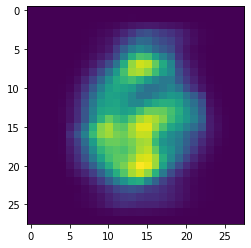

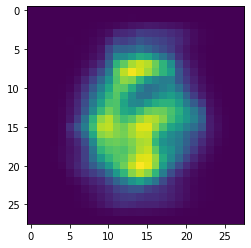

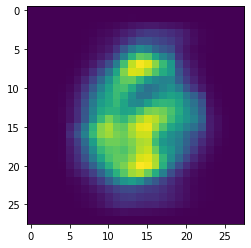

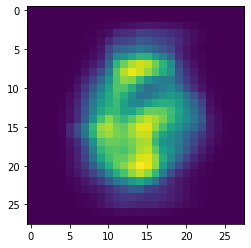

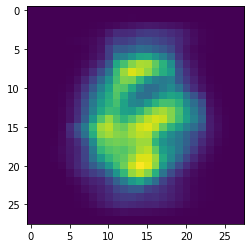

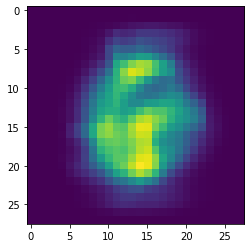

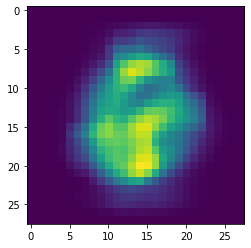

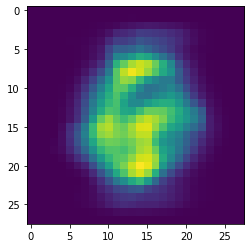

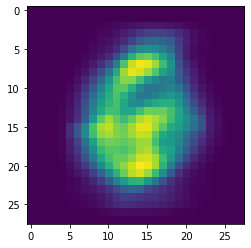

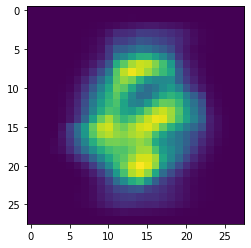

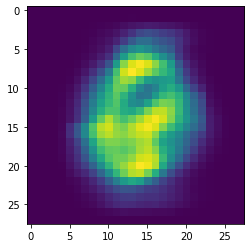

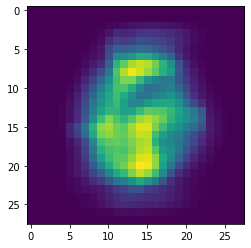

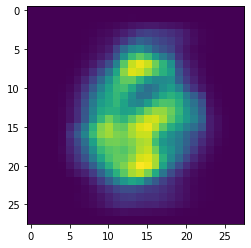

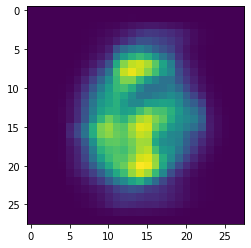

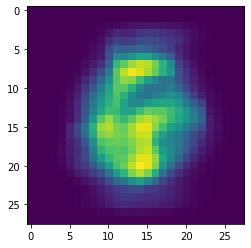

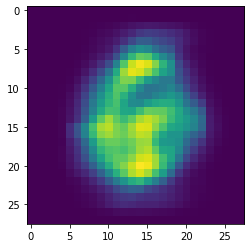

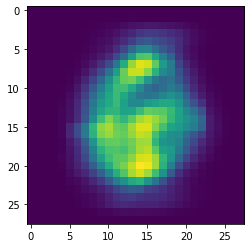

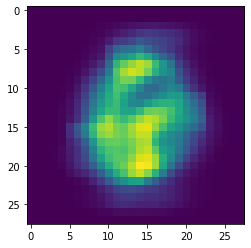

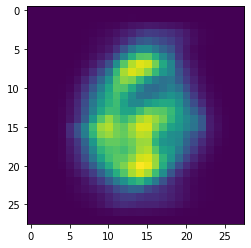

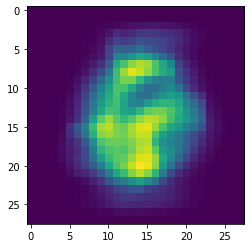

In [ ]:
X_prior_imshape = X_p_norm.reshape((X_p_norm.shape[0], 28, 28, 1))

_, Z_prior = classifier_encoder.predict(X_prior_imshape)

sigma_prior = np.dot(Z_prior.T, Z_prior) / (len(Z_prior) - 1)

#Regularize
sigma_prior = (np.diagonal(sigma_prior) * 1e-6) + sigma_prior

def inv(m):
    a, b = m.shape
    if a != b:
        raise Exception("Not same shape")
        
    i = np.eye(a, a)
    return np.linalg.lstsq(m, i)[0]

inv_sigma_prior = inv(sigma_prior)

inverse_brackets = inv(inv_sigma_prior + B@inv_sigma_likelihood@B.T)
formula = inverse_brackets@B@inv_sigma_likelihood
formula.shape

#Use formula to reconstruct X_prior from y
latent_recons = np.array([formula@y for y in Y_testing])
x_recons = decoder.predict(latent_recons)
#Un-normalise - have to flatten & un-flatten
x_recon_flat = np.array([x.flatten() for x in x_recons])
x_recons = x_p_scaler.inverse_transform(x_recon_flat)
#Visualise
for i in range(20):
    plt.imshow(x_recons[i].reshape(28,28).T)
    plt.show()